In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from Steinmetz experiments

For this assignment, we'll use some data from mouse experiments performed by Nick Steinmetz and colleagues and described in the paper here: https://www.nature.com/articles/s41586-019-1787-x.

This data was used as part of the Neuromatch Academy 2020 online summer school and has a nice video explaining it here: https://www.youtube.com/watch?v=WXn4-FpVaOo.

To summarize briefly, spiking activity from neurons in many brain regions was recorded in mice performing a decision-making task. In the task, visual gratings appeared on the left and right side before a head-fixed mouse, and the mouse had a turn a steering wheel toward the grating with higher contrast in order to obtain a reward.

In [2]:
# Retrieve the data from online and save it to local .npz files.

import os, requests

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)


In [3]:
# Load all of the data into one big array

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# Select just one session of the recordings here:
dat = alldat[0]

# Each element of alldat is a Python dictionary with keys describing the different types of data:
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




Let's look at how many neurons were recorded from each brain area.

In [4]:
n_min = 30  # keep brain areas with at least this many neurons
area_list = []
for area in set(dat['brain_area']):
    #if list(dat['brain_area']).count(area) > n_min:
    #    area_list.append(area)   
    print(area, '\t Number of neurons: ', list(dat['brain_area']).count(area))

LS 	 Number of neurons:  139
CA3 	 Number of neurons:  68
DG 	 Number of neurons:  34
root 	 Number of neurons:  18
MOs 	 Number of neurons:  113
ACA 	 Number of neurons:  109
VISp 	 Number of neurons:  178
SUB 	 Number of neurons:  75


# Visualizing neural activity

Let's start by plotting the time-dependent neural activity from some neurons from a particular brain area. 

In [5]:
area = 'MOs'
mask = dat['brain_area']==area
spikes = dat['spks'][mask,:,:]  # get the spiking data from all of the neurons in this brain area

n_neurons, n_trials, n_timebins = np.shape(spikes)
print(np.shape(spikes))  # this array has shape n_neurons by n_trials by n_timebins

(113, 214, 250)


First we'll plot the activity of one neuron from several different trials.

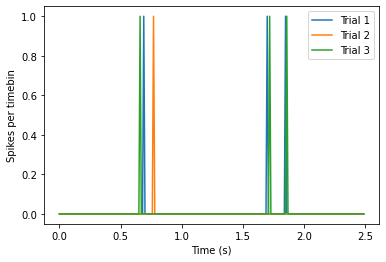

In [6]:
dt = dat['bin_size']  # duration of each time bin (i.e. 10ms--see the data description above)
t_array = dt*np.arange(0, n_timebins)  # an array of time points in seconds

for i in range(3):
    plt.plot(t_array, spikes[2,i,:])  # we'll look at neuron number 2
    
plt.xlabel('Time (s)')
plt.ylabel('Spikes per timebin')
plt.legend(['Trial 1', 'Trial 2', 'Trial 3'])

From this we can see that, since a given neuron might only spike one or a handful of times in a given trial, it's difficult to piece together what's going on by looking at the data in this way. We can get something that looks a bit more informative by looking at the neural activity averaged over trials.

In [7]:
# Average over all trials:
spikes_avg = np.mean(spikes, axis=1)
print(np.shape(spikes_avg))  # this array has shape n_neurons by n_timebins

(113, 250)


Text(0.5, 1.0, 'Neuron 0')

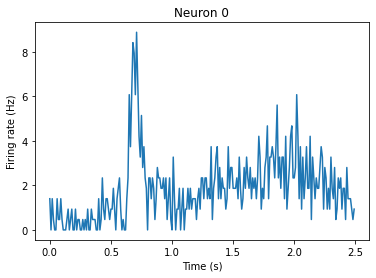

In [8]:
plt.plot(t_array, spikes_avg[2]/dt)  # dividing by dt converts the units from spikes/timebin to spikes/s
    
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.title('Neuron 0')

Maybe we can see some higher activity levels just after the cue appears (at 0.5s) and around the response time (around 1.5-2s), but it's difficult to be sure. 

Rather than averaging over all of the trials, let's next use a mask to separate the trials into different groups according to what the mouse's response was.

For the same neuron that's plotted above, let's average the firing rate separately over trials where the mouse chooses left (i.e. trials for which `dat['response']=1`) and trials where the mouse chooses right (i.e. trials for which `dat['response']=-1`). We can then plot the time-dependent firing rates for these two cases in the same plot and make a legend to explain what the two colors correspond to.

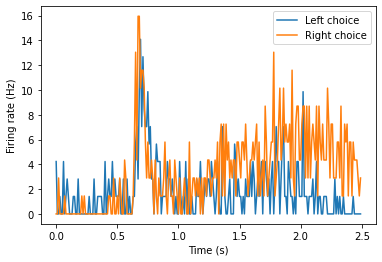

In [9]:
# Separate trials with left and right responses:
maskL = dat['response']==1
maskR = dat['response']==-1
spikesL = spikes[:,maskL,:]
spikesR = spikes[:,maskR,:]

# Average over trials:
spikesL_trialavg = np.mean(spikesL, axis=1)
spikesR_trialavg = np.mean(spikesR, axis=1)

# Plot the results for one neuron:
plt.plot(t_array, spikesL_trialavg[2,:]/dt)
plt.plot(t_array, spikesR_trialavg[2,:]/dt)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
#plt.title('Neuron 0')
plt.legend(['Left choice', 'Right choice'])

From this trial-averaged data, it looks like there is some information about the mouse's choice in this neuron's firing rate, but it's pretty noisy.

Let's next average the neural activity over time (without averaging over trials as in the above plot) in the 250ms before the response time in each trial. Note that the response time is different in each trial, and that the response times are recorded in `dat['response_time']`, as described above.

In [10]:
time_window = 25  # number of timebins to average over

response_times = dat['response_time']  # response time from each trial (in s)
spikes_timeavg = np.zeros((n_neurons, n_trials))
for i in range(n_trials):
    # timebin in which the response occurred:
    response_timebin = int(response_times[i]/dt)
    
    # average over the time window for trial i:
    spikes_timeavg[:,i] = np.mean(spikes[:,i,response_timebin-time_window:response_timebin], axis=1)

spikes_timeavg = spikes_timeavg/dt  # convert units from spikes/bin to spikes/s

# Separate the data from left- and right-choice trials
spikes_L = spikes_timeavg[:,maskL]
spikes_R = spikes_timeavg[:,maskR]

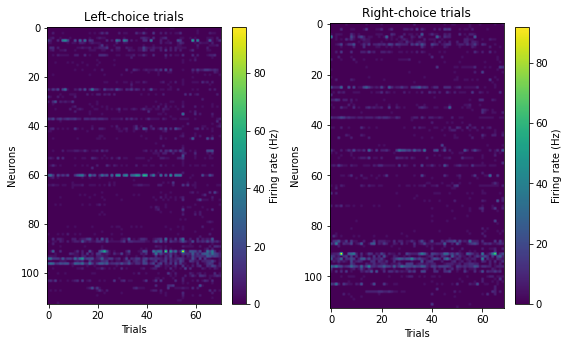

In [11]:
# Plot the time-averaged activities of all neurons in the two types of trials.

plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(spikes_L)
plt.xlabel('Trials')
plt.ylabel('Neurons')
plt.title('Left-choice trials')
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Firing rate (Hz)')

plt.subplot(122)
plt.imshow(spikes_R)
plt.xlabel('Trials')
plt.ylabel('Neurons')
plt.title('Right-choice trials')
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Firing rate (Hz)')

plt.tight_layout()

From this plot, it looks like there are some neurons with similar activity in left- and right-choice trials and other neurons with different activity in left- and right-choice trials. 

In the rest of this notebook we will answer the following question: If we imagine being given the neural activity from a trial without knowing whether the trial was a left- or right-choice trial, would we be able to guess which choice the animal made?

## Predicting choice with population selectivities

As a first approach, let's categorize neurons as either left-choice-preferring (if their trial-averaged firing rates are higher in left- than in right-choice trials) or right-choice-preferring (if their trial-averaged firing rates are higher in right- than in left-choice trials).

We will use the following selectivity index:
$$
s_i = \frac{r^L_i - r^R_i}{r^L_i + r^R_i},
$$
where $r^L_i$ is the activity of neuron $i$ averaged over left-choice trials, and $r^R_i$ is the activity of neuron $i$ averaged over right-choice trials. If neuron $i$ is more active in left-choice than in right-choice trials, we will have $s_i > 0$, and we can refer to it as a left-choice-preferring neuron. If, on the other hand, neuron $i$ is more active in right-choice than in left-choice trials, we will have $s_i < 0$, and we can refer to it as a right-choice-preferring neuron.

Text(0, 0.5, 'Count')

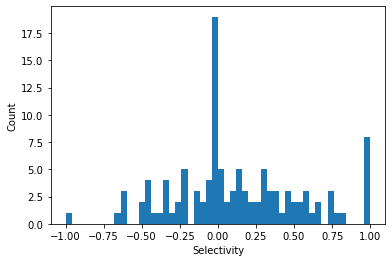

In [12]:
# Define a selectivity index based on the difference in firing during L vs. R trials:
num = np.mean(spikes_L, axis=1) - np.mean(spikes_R, axis=1)
den = np.mean(spikes_L, axis=1) + np.mean(spikes_R, axis=1)
selectivities = num/(1e-4 + den)  # the small number in the denominator prevents division by zero

# Plot a histogram of the selectivities for each neuron:
plt.hist(selectivities, bins=50)
plt.xlabel('Selectivity')
plt.ylabel('Count')

Our goal is to come up with a simple measure of the neural activity that will be predictive of the animal's choice. Let us define $L_n$ as the mean (i.e. averaged over neurons) activity of all left-preferring neurons in trial $n$, and $R_n$ as the mean activity of all right-preferring neurons in trial $n$. We can then define $D_n = L_n/\bar{L} - R_n/\bar{R}$ as the difference in the activities of left-preferring and right-preferring neurons. We have also divided the activities by their averages, just in case one population of neurons tends to have a higher firing rate on average than the other, which would bias the results. We can see that $D_n > 0$ when left-choice-preferring neurons are more active, and $D_n < 0$ when right-choice-preferring neurons are more active. Thus, given the neural activity from a particular trial, we can compute $D_n$, look at its sign, and use that to predict whether the mouse will choose left or right on that trial.

In [13]:
mask_Lselective = selectivities > 0  # mask for left-choice-preferring neurons
mask_Rselective = selectivities < 0  # mask for right-choice-preferring neurons

# Mean activity of L- and R- selective populations in each trial:
activity_Lselective = np.mean(spikes_timeavg[mask_Lselective,:], axis=0)  # we call this L_n above
activity_Rselective = np.mean(spikes_timeavg[mask_Rselective,:], axis=0)  # we call this R_n above

activity_diff = (activity_Lselective/np.mean(activity_Lselective) 
                 - activity_Rselective/np.mean(activity_Rselective))  # we call this D_n above


**Exercise 1**

1. As we did in class when discussing classification, make a scatterplot with the values of $D_n$ along the x axis, and with the y axis denoting the choice from each trial, where 0 corresponds to a right choice and 1 corresponds to a left choice. You might find the mask variables `maskL` and `maskR` that we created above to be useful for defining the choice variables. You should find that points with $D_n > 0$ mostly correspond to left choices, while points with $D_n < 0$ mostly correspond to right choices.

2. As we did in class when discussing classification, plot the same data as a histogram, with different colors denoting left- and right-choice trials. Include a legend to explain what the colors mean.

In [14]:
### Your code here ###


In [15]:
### Your code here ###


**Exercise 2**

Classify each point above according to whether its value of $D_n$ is positive or negative. Compute the fraction of points for which the classification of the mouse's choice based on this value is correct.

In [16]:
### Your code here ###


A minor point: A more correct way to do the classification would incorporate cross-validation by defining selectivities using a one set of trials ("training data") and testing the classification using the activities from the remaining trials ("testing data"). This would reduce the above result somewhat and make for a more apples-to-apples comparison with the classification scores that we find using other methods below.

## Predicting choice with logistic regression on a subset of neurons

Another approach for using neural activity to predict the mouse's choice is to use logistic regression. This is like the multivariate linear regression from the previous homework assignment, where the neural activities were used to predict the speed at which the mouse was turning a wheel, except now the thing that we are predicting is binary rather than continuous.

A problem with this approach is that, in order for it to work well, we would like the number of trials to be much larger than the number of neurons that we are using to predict the output. (For example, we wouldn't expect to get a very reliable fit for a single-variable regression if we only had one or two data points.) In this data, though, these numbers are comparable. Here we will take a somewhat naive approach of using just a subset of neurons to try to predict the mouse's choice

First we will show use neural activity to predict choice using only a subset of the neurons. We need to do this because we want to have more trials than we have neurons in order to constrain the model.

**Exercise 3**

Create a mask, `neurons_mask`, that selects the indices of the 10 neurons with the greatest absolute value of `selectivity`, which we defined above (note that this may include neurons with both large negative and large positive selectivity). Use this mask to print the selectivities of the 10 most selective neurons. Hint: the function `np.argsort()` might be useful.

In [21]:
neurons_to_keep = 10  # number of neurons to keep

### Your code here ###


Next we can do a logistic regression that uses the activities of these neurons to predict the mouse's choice in each trial.

In [37]:
# Uncomment the following three lines if you didn't get the previous exercise:
#neurons_mask = np.zeros(n_neurons)
#neurons_mask[:neurons_to_keep] = 1  # This will select just the first 10 neurons
#neurons_mask = [bool(m) for m in neurons_mask]

# Keep only trials where the mouse made a choice:
trials_mask = maskL + maskR  # trials_mask[i] is True when either maskL[i] or maskR[i] is True
choices = dat['response'][trials_mask]
y = 0.5*(choices + 1)  # Left choice is 1; right choice is 0
X = spikes_timeavg.T[trials_mask,:][:,neurons_mask]  # Use just some of the neurons

In [ ]:
# Use a regression model that has built-in cross-validation.

from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV().fit(X, y)
print('Testing accuracy: ', clf.score(X, y))

## Predicting choice with logistic regression using top PCs

Rather than using a subset of neurons to do the regression as we did above, let's use a subset of the principal components, assuming that most of the signal that we want to decode is contained in the leading PCs and that the higher PCs contain mostly noise.

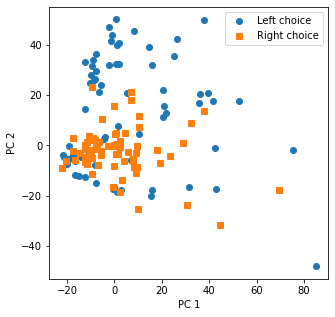

In [21]:
from sklearn.decomposition import PCA

# Subtract the mean from the data before performing PCA:
spikes_timeavg_meansub = spikes_timeavg.T - np.mean(spikes_timeavg, axis=1)

# Perform PCA on the data:
pca = PCA()
pca.fit(spikes_timeavg_meansub)
PCs = pca.components_  # each row is one of the PC vectors

# Project the data onto the principal component axes:
proj = spikes_timeavg_meansub @ PCs.T

# Separate the data points corresponding to left and right choices:
proj_L = proj[maskL,:]
proj_R = proj[maskR,:]

# Plot the data projected along the first two PCs:
plt.figure(figsize=(5,5))
plt.plot(proj_L[:,0], proj_L[:,1], 'o')
plt.plot(proj_R[:,0], proj_R[:,1], 's')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(['Left choice', 'Right choice'])

Next we will perform logistic regression just as above, except that the inputs will be the projections of the data along the first 10 PCs rather than the data from the 10 most selective neurons.

In [22]:
# Select the data from trials were a choice was made and from the first 10 PCs:
PCs_to_keep = 10
trials_mask = maskL + maskR
X = proj[trials_mask,:PCs_to_keep]

# Fit the logistic regression model:
clf = LogisticRegressionCV().fit(X, y)

print('Testing accuracy: ', clf.score(X, y))

Testing accuracy:  0.8142857142857143


In the plot below, we will project the data onto the axis perpendicular to the classification boundary. This means that all of the points with positive values are predicted to be left-choice-trials, while all points with negative values are predicted to be right-choice-trials.

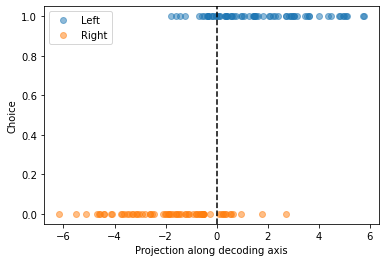

In [23]:
# The fit coefficients define a vector in the space of PCs:
decoding_axis = clf.coef_

# Project the data from PC space onto the decoding vector:
decodeL = proj_L[:,:PCs_to_keep] @ decoding_axis[0,:]
decodeR = proj_R[:,:PCs_to_keep] @ decoding_axis[0,:]

# Plot the data along the decoding axis along with the choice value:
plt.plot(decodeL, np.ones_like(decodeL), 'o', alpha=0.5)
plt.plot(decodeR, np.zeros_like(decodeR), 'o', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Projection along decoding axis')
plt.ylabel('Choice')
plt.legend(['Left', 'Right'])

In [24]:
# Look at which PCs are most aligned with the decoding vector.

for i in range(PCs_to_keep):
    print('PC '+str(i+1), '\t Weight: ', 
          abs(decoding_axis[0,i]/np.linalg.norm(decoding_axis)))

PC 1 	 Weight:  0.11628423541566596
PC 2 	 Weight:  0.3288750179205696
PC 3 	 Weight:  0.8260052722610665
PC 4 	 Weight:  0.18160411265553017
PC 5 	 Weight:  0.34164808434264465
PC 6 	 Weight:  0.13975466487736965
PC 7 	 Weight:  0.028944825933338473
PC 8 	 Weight:  0.08786751879794819
PC 9 	 Weight:  0.05462068703841495
PC 10 	 Weight:  0.12352219433974504


**Exercise 4**

1. Make a scatter plot of the data as we did above, but, rather than plotting the projection along the first two principal components, plot the projection along the two PCs that have the greatest overlap with the decoding vector (as we computed in the preceding cell). The data should look more separable than it does when plotted along the first two PCs.

2. We showed in class that the classification boundary is given by the equation
$$
\sum_{k=1}^K a_k x_k + b = 0.
$$
In this case, $K=10$ is the number of PC components that we are keeping, $x_k$ is the projection of the data along the $k$th PC, $a_k$ are the coefficients in `clf.coef_`, and $b$ is the intercept in `clf.intercept_`. Since we are plotting everything in the plane spanned by two of the $K$ PCs, we can set all of the other coefficients $a_k$ for the other PCs to zero, leaving us with the equation for a line. In the same plot from Part 1, plot the classification boundary separating the two classes of data points.

In [39]:
### Your code here ###
